In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import jieba,re,os,pickle
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader, TensorDataset
import torch.utils.data as Data
import random
import math
import time,re

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#参数
# Transformer Parameters
d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention
d_k = d_v = d_model//n_heads  # dimension of K(=Q), V #Q 与 K 的维度必须相等
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1

## 数据预处理

In [3]:
def add_space_before_punctuation(text):
    """
    在文本中的标点符号前添加一个空格。
    参数:
    text (str): 要处理的文本字符串。
    返回:
    str: 在标点符号前添加了空格的文本字符串。
    """
    # 扩展正则表达式以匹配各种标点符号，包括单引号和双引号
    pattern = r'([,.:;!?()\'"])'
    # 使用 re.sub 方法替换文本中的标点符号
    # r' \1' 表示在匹配到的标点符号前添加一个空格
    # \1 是一个反向引用，指代第一个括号内匹配的内容，即标点符号本身
    spaced_text = re.sub(pattern, r' \1', text)
    # 返回处理后的文本
    return spaced_text

text = "The fewer hours he has to spend laboring, and the more hours he is free to play, the better."
result = add_space_before_punctuation(text)
print(result)

The fewer hours he has to spend laboring , and the more hours he is free to play , the better .


In [28]:
def read_deal_train_data(file_path="./data/en_ch.txt",num=200): #导入数据 
    # 使用 read_csv 函数读取文件，指定制表符为分隔符，不读取标题行  
    data = pd.read_csv(file_path, sep='\t', header=None, error_bad_lines=False)#on_bad_lines='skip'  
    # 互换第一列和第二列  
    data[[0, 1]] = data[[1, 0]].values  
    # 初始化空列表，用于存放符合条件的数据  
    filtered_chinese = []  
    filtered_english = []  
    
    for index, row in data.iterrows():  
        X = row[0]  # 中文  
        Y = row[1]  # 英文  
        
        # 检查X是否是有效的字符串，避免空值或NaN值导致的问题  
        if not isinstance(X, str) or re.search(r'<.*?>', X):  
            continue  # 如果X无效，则跳过这一行  
        
        # 检查中文部分是否包含英文字母  
        if re.search(r'[a-zA-Z]', X):  
            continue  # 如果X包含英文字母，则跳过这一行
    
        # 检查中文中是否包含特殊符号《、》、（、）、- 等    
        if re.search(r'[《》（）-]', X):
            continue  # 如果 X 包含特殊符号，则跳过这一行
        
        # 检查Y是否是有效的字符串  
        if not isinstance(Y, str) or len(Y) <= 1:  
            continue  # 如果Y无效，则跳过这一行  

        # 因为X和Y都是有效的，可以进行处理  
        filtered_chinese.append(str(X))  
        #规则化英语
        filtered_english.append(add_space_before_punctuation(str(Y)).lower())

        if len(filtered_english)>num:
            break   
    return filtered_chinese, filtered_english
chinese_sentences,english_sentences=read_deal_train_data()

In [6]:
# 中文句子列表
chinese_sentences = [
    "你今天晚上有什么计划吗？",
    "我喜欢在周末去公园散步。",
    "这家餐厅的菜很美味。",
    "我们明天需要完成这个项目。",
    "你能帮我查一下这本书的价格吗？",
    "昨天的电影真是太有趣了。",
    "他正在学习如何编程。",
    "你知道最近的天气预报吗？",
    "我们计划下个月去旅行。",
    "她在音乐会上表演得非常出色。"
]

# 英文句子列表
english_sentences = [
    "Do you have any plans for tonight?",
    "I enjoy taking walks in the park on weekends.",
    "The food at this restaurant is delicious.",
    "We need to finish this project by tomorrow.",
    "Can you help me check the price of this book?",
    "The movie yesterday was really interesting.",
    "He is learning how to code.",
    "Do you know the latest weather forecast?",
    "We plan to go on a trip next month.",
    "She performed exceptionally well at the concert."
]
english_sentences=[add_space_before_punctuation(str(Y)).lower() for Y in english_sentences]

In [7]:
#分词
def tokenize_chinese(sentence):#分词
    return list(jieba.cut(sentence))
tokenized_chinese = [tokenize_chinese(sentence) for sentence in chinese_sentences]
tokenized_english = [sentence.split() for sentence in english_sentences]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\qiqi\AppData\Local\Temp\jieba.cache
Loading model cost 0.578 seconds.
Prefix dict has been built successfully.


In [8]:
#数据填充-不填<PAD>
padded_english = [ ['<start>'] + tokens + ['<end>'] for tokens in tokenized_english ] 
padded_chinese = [ ['<start>'] + tokens + ['<end>'] for tokens in tokenized_chinese ] 

In [9]:
#生成词表
chinese_vocab = {'<pad>': 0 ,'<start>': 1, '<end>': 2}#中文
for sentence in padded_chinese:
    for token in sentence:
        if token not in chinese_vocab:
            chinese_vocab[token] = len(chinese_vocab)
#保存中文字典
with open('./vocab/Transformer_chinese_vocab.pkl', 'wb') as f:  
    pickle.dump(chinese_vocab, f)
tgt_vocab_size=len(chinese_vocab)

english_vocab = {'<pad>': 0 ,'<start>': 1, '<end>': 2} #英文
for sentence in padded_english:
    for token in sentence:
        if token not in english_vocab:
            english_vocab[token] = len(english_vocab)
src_vocab_size=len(english_vocab)
#保存英文字典
with open('./vocab/Transformer_english_vocab.pkl', 'wb') as f:  
    pickle.dump(english_vocab, f)

In [10]:
indexed_chinese = [[chinese_vocab[token] for token in sentence] for sentence in padded_chinese]
indexed_english = [[english_vocab[token] for token in sentence] for sentence in padded_english]

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, indexed_english, indexed_chinese,device=device):
        self.indexed_english = indexed_english
        self.indexed_chinese = indexed_chinese

    def __len__(self):
        return len(self.indexed_english)

    def __getitem__(self, idx):
        return self.indexed_english[idx], self.indexed_chinese[idx]
    
    def batch_data_process(self,batch_datas,pad=0,max_len=128):#按批次填充，<PAD>=0，默认
        en_index, ch_index = [], []

        for en, ch in batch_datas:
            # 截断英文数据，并填充至 max_len
            if len(en) > max_len:
                en = en[:max_len]
            else:
                en = en + [pad] * (max_len - len(en))

            # 截断中文数据，并填充至 max_len
            if len(ch) > max_len:
                ch = ch[:max_len]
            else:
                ch = ch + [pad] * (max_len - len(ch))

            en_index.append(en)
            ch_index.append(ch)

        # 转换为PyTorch张量并指定设备
        en_index = torch.tensor(en_index, device=device)
        ch_index = torch.tensor(ch_index, device=device)
        return en_index,ch_index

In [12]:
# 创建 Dataset
dataset = TranslationDataset(indexed_english, indexed_chinese)
# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dataset.batch_data_process)

## Positional Encoding
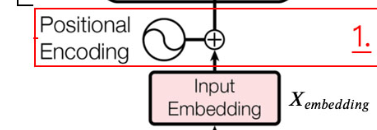
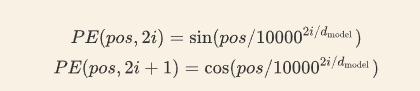
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
通过一个具体的例子来解释 `div_term` 的计算过程。假设 `d_model` 设置为 8，那么以下代码：

```python
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
```

可以分解为以下步骤：

1. **生成范围**：
   ```python
   torch.arange(0, d_model, 2).float()
   ```
   生成从 `0` 到 `d_model-1` 的偶数序列。对于 `d_model=8`，生成的序列是：
   ```python
   tensor([0., 2., 4., 6.])
   ```

2. **计算缩放因子**：
   ```python
   -math.log(10000.0) / d_model
   ```
   计算常数项 `-math.log(10000.0) / d_model`。对于 `d_model=8`，这个值是：
   ```python
   -math.log(10000.0) / 8 ≈ -9.21034 / 8 ≈ -1.15129
   ```

3. **乘法运算**：
   ```python
   torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
   ```
   将之前生成的偶数序列乘以缩放因子。计算结果是：
   ```python
   tensor([0.0 * -1.15129, 2.0 * -1.15129, 4.0 * -1.15129, 6.0 * -1.15129])
   tensor([0.0, -2.30258, -4.60517, -6.90776])
   ```

4. **计算指数**：
   ```python
   torch.exp(tensor([0.0, -2.30258, -4.60517, -6.90776]))
   ```
   对结果应用指数函数。计算得到：
   ```python
   tensor([1.0, 0.1, 0.01, 0.001])
   ```

### 示例代码

```python
import torch
import math

d_model = 8
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print(div_term)
```

### 输出

```
tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03])
```

### 解释

- **`torch.arange(0, d_model, 2).float()`**：生成的偶数序列 `[0, 2, 4, 6]`。
- **`-math.log(10000.0) / d_model`**：常数项 `-1.15129` 用于调整缩放因子。
- **乘法运算**：得到 `[0, -2.30258, -4.60517, -6.90776]`。
- **`torch.exp()`**：对结果应用指数函数，得到 `[1.0, 0.1, 0.01, 0.001]`，这些是不同频率的缩放因子，用于位置编码。

这些缩放因子 (`div_term`) 用于调整正弦和余弦函数的频率，以确保每个维度的编码具有不同的频率，使得每个位置的编码都是唯一的。


`torch.arange(0, d_model, 2)` 生成的是一个从 0 到 `d_model-1`（步长为 2）的偶数序列，用于计算 `div_term`。具体来说，这个序列的每个元素表示计算位置编码时需要的不同频率的幂次。

让我们逐步解释 Transformer 论文中的位置编码公式，并将其与代码中的计算方法对应起来：

### Transformer 论文中的公式

在 Transformer 论文中，位置编码的公式为：

$$
\text{PE}(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d\_model}}\right)
$$
$$
\text{PE}(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d\_model}}\right)
$$
- `pos` 是位置索引。
- `2i` 和 `2i+1` 表示编码的维度（偶数维度和奇数维度）。

### 代码中的实现

在代码中，`div_term` 的计算是：

```python
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
```

这实际上是对 Transformer 论文公式的一个等效实现：

1. **指数部分**：`10000^{2i/d_model}` 可以转换为对数形式，`exp` 函数用于计算指数。
$$
\text{PE}(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d\_model}}}\right)
$$
2. **计算 `div_term`**：

   \[
   \text{div\_term}[i] = e^{(2i/d\_model) \cdot \log(10000)}
   \]

   这里 `torch.arange(0, d_model, 2)` 生成了偶数序列 `0, 2, 4, ..., d_model-2`，对应 `2i`。

   `-math.log(10000.0) / d_model` 是 `\log(10000)` 的负值，再除以 `d_model`，用于计算缩放因子。这样 `exp` 的计算会产生与 `10000^{2i/d_model}` 对应的值。

### 总结

- `torch.arange(0, d_model, 2)` 生成偶数索引，这些索引用于计算不同频率的缩放因子。
- `div_term` 是用 `exp` 函数计算的，以实现和论文中相同的频率计算方式。

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        """
        初始化PositionalEncoding模块。
        :param d_model: 嵌入向量的维度。
        :param dropout: Dropout层的丢弃概率，用于防止过拟合。
        :param max_len: 序列的最大长度。
        """
        super(PositionalEncoding, self).__init__()
        # 定义Dropout层
        self.dropout = nn.Dropout(p=dropout)
        # 创建位置编码矩阵，大小为 (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        # 生成位置索引 [0, 1, 2, ..., max_len-1] 并扩展为列向量
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        """
        tensor([0.0, 1.0, 2.0, 3.0])
        .unsqueeze(1)后
        tensor([[0.0],
            [1.0],
            [2.0],
            [3.0]])
        """
        # 计算位置编码中的“缩放因子” (div_term)，用于生成不同频率的正弦和余弦函数
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # 对偶数维度应用正弦函数
        pe[:, 0::2] = torch.sin(position * div_term)
        # 对奇数维度应用余弦函数
        pe[:, 1::2] = torch.cos(position * div_term)
        # 将pe的形状调整为 (1, max_len, d_model) 并进行转置
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        # 注册pe为模型的缓冲区，以便在保存和加载模型时保持其值
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        前向传播函数。
        :param x: 输入张量，形状为 (seq_len, batch_size, d_model)。
        :return: 加入位置编码后的张量。
        """
        # x的形状为 (seq_len, batch_size, d_model)，
        # self.pe的形状为 (1, max_len, d_model)，
        # 所以将self.pe裁剪到与x的序列长度相同
        x = x + self.pe[:x.size(0), :]# max_len ！= seq_len
        
        # 应用Dropout层
        return self.dropout(x)

## Pad Mask

让我们详细演示如何生成 `pad_attn_mask`，使用你提供的 `seq_q` 和 `seq_k`。下面的代码展示了如何从这两个序列创建 PAD 掩码，并将其扩展到每个查询步骤。

### 输入数据

```python
import torch

# Query sequences and Key sequences
seq_q = torch.tensor([
    [1, 2, 3, 0, 0],  # Query sequence for batch 1
    [2, 100, 3, 4, 0]   # Query sequence for batch 2
])

seq_k = torch.tensor([
    [1, 2, 3, 0, 0],  # Key sequence for batch 1
    [2, 100, 3, 4, 0]    # Key sequence for batch 2
])
```

### 步骤 1: 创建 PAD 掩码

首先，我们需要标记 `seq_k` 中的 PAD 位置：

```python
pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
```

解释：
- `seq_k.data.eq(0)`：生成一个布尔掩码，标记值为 `0` 的位置为 `True`，其他位置为 `False`。
- `unsqueeze(1)`：在第二维添加一个维度，将掩码的形状从 `[batch_size, seq_len_k]` 变为 `[batch_size, 1, seq_len_k]`。

生成的 `pad_attn_mask` 是：

```python
pad_attn_mask = torch.tensor([
    [[False, False, False, True, True]],  # Mask for batch 1
    [[False, False, False, True, True]]   # Mask for batch 2
])
```

### 步骤 2: 扩展掩码

然后，我们将掩码扩展到查询序列的每一个时间步：

```python
batch_size, len_q = seq_q.size()
len_k = seq_k.size(1)
pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
```

解释：
- `expand(batch_size, len_q, len_k)`：将掩码的形状从 `[batch_size, 1, len_k]` 扩展到 `[batch_size, len_q, len_k]`。

扩展后的 `pad_attn_mask` 是：

```python
pad_attn_mask = torch.tensor([
    [[False, False, False, True, True],  # Expanded mask for query step 1
     [False, False, False, True, True],  # Expanded mask for query step 2
     [False, False, False, True, True],  # Expanded mask for query step 3
     [False, False, False, True, True],  # Expanded mask for query step 4
     [False, False, False, True, True]], # Expanded mask for query step 5
    [[False, False, False, True, True],  # Expanded mask for query step 1
     [False, False, False, True, True],  # Expanded mask for query step 2
     [False, False, False, True, True],  # Expanded mask for query step 3
     [False, False, False, True, True],  # Expanded mask for query step 4
     [False, False, False, True, True]]  # Expanded mask for query step 5
])
```

### 总结

`pad_attn_mask` 的形状是 `[2, 5, 5]`，其中 `2` 是批量大小，`5` 是序列长度。掩码的每一层 `[False, False, False, True, True]` 对应于 `seq_k` 中的 PAD 位置，确保在计算注意力时，PAD 位置不会对结果产生影响。


In [14]:
def get_attn_pad_mask(seq_q, seq_k):  
    '''  
    seq_q: [batch_size, seq_len]  # 查询序列，形状为(batch_size, seq_len)  
    seq_k: [batch_size, seq_len]  # 键序列，形状为(batch_size, seq_len)  
    seq_len可以是源序列的长度(source length)或目标序列的长度(target length)  
    seq_q中的seq_len和seq_k中的seq_len可能不相等  
    '''  
    batch_size, len_q = seq_q.size()  # 获取查询序列的batch大小和长度  
    batch_size, len_k = seq_k.size()  # 获取键序列的batch大小和长度  
    
    # eq(zero)是PAD标记，通常PAD标记的值为0  
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # 创建一个掩码，标记键序列中PAD的位置  
    # 这里的pad_attn_mask的形状为[batch_size, 1, len_k]，其中True表示被掩蔽的位置  
    
    # 扩展掩码，使其适用于查询序列的每一个时间步  
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # 返回的掩码形状为[batch_size, len_q, len_k]  

## Subsequence Mask(Decoder )
假设我们有一个批次的序列数据，`batch_size` 为 2，`tgt_len` 为 4。也就是说，我们有 2 个序列，每个序列的长度都是 4。我们用一个简单的示例来说明如何生成掩码。
### 输出

对于 `batch_size = 2` 和 `tgt_len = 4`，生成的掩码将是一个形状为 `[2, 4, 4]` 的张量。掩码的每个矩阵都会是一个上三角矩阵，其形状如下：

```python
tensor([[[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]]], dtype=torch.uint8)
```

### 解释

这个掩码的每一行表示当前标记能够关注的内容：
- 第一个标记（索引 0）可以关注到所有其他标记（索引 1, 2, 3），因此掩码的第一行是 `[0, 1, 1, 1]`。
- 第二个标记（索引 1）只能关注到标记 1 及其后面的标记（索引 2, 3），因此掩码的第二行是 `[0, 0, 1, 1]`。
- 第三个标记（索引 2）只能关注到标记 2 及其后面的标记（索引 3），因此掩码的第三行是 `[0, 0, 0, 1]`。
- 第四个标记（索引 3）不能关注任何标记，因此掩码的第四行是 `[0, 0, 0, 0]`。

这个掩码确保了模型在生成或预测时，只能关注当前和过去的标记，而不能看到未来的标记，从而模拟自回归模型的训练和推理过程。

In [15]:
def get_attn_subsequence_mask(seq):
    '''
    生成一个掩码，防止模型在序列中关注未来的标记。
    参数:
        seq (Tensor): 一个形状为 [batch_size, tgt_len] 的张量，其中 batch_size 是批次中的序列数，
                      tgt_len 是每个序列的长度。
    返回:
        Tensor: 形状为 [batch_size, tgt_len, tgt_len] 的二进制掩码，其中每个批次中的矩阵都具有上三角结构，
                上三角部分填充 1（阻止未来标记），其余部分填充 0（允许的标记）。
    '''
    # 根据目标序列长度确定掩码的形状
    # 每个序列的掩码形状为 [tgt_len, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # 创建一个上三角矩阵，主对角线上的 1 表示可以关注的标记，上三角部分的 1 表示阻止关注的未来标记
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 上三角矩阵，主对角线以上的部分为 1
    # 将 numpy 数组转换为 PyTorch 张量，并确保其数据类型为 byte
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  # 转换为 PyTorch 张量，数据类型为 byte
    return subsequence_mask  # 返回形状为 [batch_size, tgt_len, tgt_len] 的掩码张量

## Scaled_Dot_Product_Attention

In [16]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        '''
        初始化 ScaledDotProductAttention 类的实例。
        '''
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        前向传播函数，计算缩放点积注意力机制。
        
        参数:
            Q (Tensor): 查询张量，形状为 [batch_size, n_heads, len_q, d_k]。
            K (Tensor): 键张量，形状为 [batch_size, n_heads, len_k, d_k]。
            V (Tensor): 值张量，形状为 [batch_size, n_heads, len_v(=len_k), d_v]。
            attn_mask (Tensor): 注意力掩码，形状为 [batch_size, n_heads, seq_len, seq_len]。
            
        返回:
            context (Tensor): 上下文向量，形状为 [batch_size, n_heads, len_q, d_v]。
            attn (Tensor): 注意力权重，形状为 [batch_size, n_heads, len_q, len_k]。
        '''
        # 计算点积得分，得分的形状为 [batch_size, n_heads, len_q, len_k]
        # Q 和 K 的维度 d_k 需要被缩放，以避免点积结果过大
        # K.transpose(-1, -2) 的形状为 [batch_size, n_heads, d_k, len_k]
        # Q:[batch_size, n_heads, len_q, d_k] * [batch_size, n_heads, d_k, len_k]
        #最后两个维度矩阵乘法
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        # 使用掩码填充得分矩阵中的无效位置，填充值为 -1e9，确保这些位置在 softmax 计算时不会被选中
        scores.masked_fill_(attn_mask, -1e9)#[batch_size, n_heads, len_q, len_k]
        # 对得分应用 softmax，计算注意力权重
        attn = nn.Softmax(dim=-1)(scores)#[batch_size, n_heads, len_q, len_k]
        # 使用注意力权重对值张量进行加权求和，得到上下文向量，形状为 [batch_size, n_heads, len_q, d_v]
        context = torch.matmul(attn, V)#[batch_size, n_heads, len_q, d_v]
        return context, attn

## MultiHeadAttention

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        '''
        初始化 MultiHeadAttention 类的实例。
        '''
        super(MultiHeadAttention, self).__init__()
        # 线性变换，用于生成查询向量 Q 的权重矩阵，输出维度为 d_k * n_heads。
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        # 线性变换，用于生成键向量 K 的权重矩阵，输出维度为 d_k * n_heads。
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        # 线性变换，用于生成值向量 V 的权重矩阵，输出维度为 d_v * n_heads。
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        # 线性变换，用于将多头注意力的输出映射回 d_model 维度。
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)

    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        前向传播函数，计算多头注意力机制。
        参数:
            input_Q (Tensor): 查询张量，形状为 [batch_size, len_q, d_model]。
            input_K (Tensor): 键张量，形状为 [batch_size, len_k, d_model]。
            input_V (Tensor): 值张量，形状为 [batch_size, len_v(=len_k), d_model]。
            attn_mask (Tensor): 注意力掩码，形状为 [batch_size, seq_len, seq_len]。
        返回:
            output (Tensor): 多头注意力机制的输出，形状为 [batch_size, len_q, d_model]。
            attn (Tensor): 注意力权重，形状为 [batch_size, n_heads, len_q, len_k]。
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # 通过线性变换将输入映射到多头注意力的查询、键和值空间，并调整维度。
        # 然后通过 view 和 transpose 操作，准备进行多头注意力计算。
        #Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # Q: [batch_size, n_heads, len_q, d_k]
        Q=self.W_Q(input_Q)
        #print(Q.shape)
        Q=Q.view(batch_size, -1, n_heads, d_k)#有多少个头就劈多少段
        #print(Q.shape)
        Q=Q.transpose(1, 2)#更换维度
        #print(Q.shape)
        """
        torch.Size([2, 5, 8])
        torch.Size([2, 5, 2, 4])
        torch.Size([2, 2, 5, 4])
        """
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]
        # 将掩码调整为适应多头注意力的维度，并重复扩展到每一个头。
        
        #unsqueeze 是一个非常实用的函数，用于在指定位置增加一个维度
        #.repeat(1, n_heads, 1, 1),在相应位置，重复n_heads 次
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)  # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        # 使用缩放点积注意力机制计算上下文向量和注意力权重。
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        # 将上下文向量从多头维度恢复为单一的注意力维度，并通过线性层映射回 d_model 维度。
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v)  # context: [batch_size, len_q, n_heads * d_v]
        # 使用全连接层将多头注意力的输出映射到原始的 d_model 维度。
        output = self.fc(context)  # [batch_size, len_q, d_model]
        # 将残差连接和层归一化应用于输出，并返回最终结果。
        return nn.LayerNorm(d_model).to(device)(output + residual), attn

## FeedForward Layer

In [18]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        # 定义前馈网络，包括两个线性层和一个ReLU激活函数
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),  # 第一个线性层，将输入从d_model维度映射到d_ff维度
            nn.ReLU(),                            # ReLU激活函数，增加非线性
            nn.Linear(d_ff, d_model, bias=False)  # 第二个线性层，将d_ff维度映射回d_model维度
        )

    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs  # 保存输入以便后续添加残差

        output = self.fc(inputs)  # 将输入传入前馈网络 [batch_size, seq_len, d_model]

        # 添加残差连接并进行层归一化
        return nn.LayerNorm(d_model).to(device)(output + residual)  # [batch_size, seq_len, d_model]

## Encoder Layer

In [19]:
class EncoderLayer(nn.Module):#自注意力
    def __init__(self):
        super(EncoderLayer, self).__init__()
        # 初始化多头自注意力机制
        self.enc_self_attn = MultiHeadAttention()
        # 初始化前馈网络
        self.pos_ffn = PoswiseFeedForwardNet()
    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        输入的形状是 [批次大小, 源序列长度, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        自注意力掩码，形状为 [批次大小, 源序列长度, 源序列长度]
        '''
        # 通过多头自注意力机制处理输入
        # enc_outputs: [batch_size, src_len, d_model]
        # attn: [batch_size, n_heads, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        # 通过前馈网络处理自注意力的输出
        enc_outputs = self.pos_ffn(enc_outputs)  # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

## Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # 词嵌入层，将词汇索引映射到d_model维度的向量
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        # 位置编码，用于加入位置信息
        self.pos_emb = PositionalEncoding(d_model)
        # 定义n_layers个EncoderLayer层
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        输入的形状是 [批次大小, 源序列长度]
        '''
        # 将输入索引转换为嵌入向量
        enc_outputs = self.src_emb(enc_inputs)  # [batch_size, src_len, d_model]
        # 添加位置编码，并恢复维度
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)  # [batch_size, src_len, d_model]
        # 生成自注意力的掩码
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)  # [batch_size, src_len, src_len]

        enc_self_attns = []

        # 逐层处理编码器层
        for layer in self.layers:
            # 处理每一层的输入，得到输出和注意力权重
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)  # 保存每层的注意力权重
        return enc_outputs, enc_self_attns

## Decoder Layer

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        # 初始化自注意力机制，用于处理目标序列的自注意力
        self.dec_self_attn = MultiHeadAttention()
        # 初始化编码器-解码器注意力机制，用于处理目标序列与源序列之间的注意力
        self.dec_enc_attn = MultiHeadAttention()
        # 初始化前馈网络
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        解码器输入，形状为 [批次大小, 目标序列长度, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        编码器的输出，形状为 [批次大小, 源序列长度, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        解码器自注意力的掩码，形状为 [批次大小, 目标序列长度, 目标序列长度]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        解码器-编码器注意力的掩码，形状为 [批次大小, 目标序列长度, 源序列长度]
        '''
        # 通过解码器的自注意力机制处理输入
        # dec_outputs: [batch_size, tgt_len, d_model]
        # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)

        # 通过解码器的编码器-解码器注意力机制处理输出
        # dec_outputs: [batch_size, tgt_len, d_model]
        # dec_enc_attn: [batch_size, n_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)

        # 通过前馈网络处理解码器的输出
        dec_outputs = self.pos_ffn(dec_outputs)  # [batch_size, tgt_len, d_model]

        # 返回处理后的输出以及注意力权重
        return dec_outputs, dec_self_attn, dec_enc_attn

## Decoder


`torch.gt` 是 PyTorch 中的一个函数，用于执行大于比较操作。具体来说，`torch.gt(input, other)` 会逐元素比较 `input` 和 `other`，如果 `input` 中的元素大于 `other` 中对应的元素，则返回 `True`（或者在布尔张量中是 `1`），否则返回 `False`（或者是 `0`）。这个操作是逐元素的，即元素级的比较。

在你的代码中：

```python
dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda()
```

### 代码解析

1. **`dec_self_attn_pad_mask`** 和 **`dec_self_attn_subsequence_mask`** 是两个掩码张量：
   - `dec_self_attn_pad_mask` 用于掩盖填充部分（padding）。
   - `dec_self_attn_subsequence_mask` 用于掩盖目标序列中未来的部分（即防止信息泄露）。

2. **加法操作**：`dec_self_attn_pad_mask + dec_self_attn_subsequence_mask` 将两个掩码相加。这种加法通常会得到一个新张量，其中填充值和未来信息的掩码位置的和可能是 `0` 或者大于 `0` 的值。具体取决于原始掩码的值。

3. **`torch.gt(..., 0)`**：
   - `torch.gt` 将新张量与 `0` 进行比较，得到一个布尔张量，其中的元素如果大于 `0`，则该位置为 `True`（在布尔张量中表示为 `1`），否则为 `False`（表示为 `0`）。
   - 这个操作会将掩码张量的元素值大于 `0` 的位置标记为 `True`，否则标记为 `False`。它有效地合并了填充掩码和子序列掩码，形成一个最终的自注意力掩码。

4. **`.cuda()`**：将生成的布尔张量转移到 GPU 上，以便进行 GPU 加速的计算。

### 总结

`torch.gt` 的作用是对张量的每个元素进行大于比较操作，并返回一个布尔张量。在你的代码中，它用于生成最终的自注意力掩码，掩码中 `0` 位置的元素会被标记为 `False`（或者 `0`），大于 `0` 的元素会被标记为 `True`（或者 `1`）。这对于掩盖不需要注意的位置（如填充部分和未来部分）是非常重要的。

In [22]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # 目标语言的词嵌入层，将目标词汇索引映射到d_model维度的向量
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        # 位置编码，用于为目标序列添加位置信息
        self.pos_emb = PositionalEncoding(d_model)
        # 定义n_layers个DecoderLayer层
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        解码器的输入，形状为 [批次大小, 目标序列长度]

        enc_inputs: [batch_size, src_len]
        编码器的输入，形状为 [批次大小, 源序列长度]

        enc_outputs: [batch_size, src_len, d_model]
        编码器的输出，形状为 [批次大小, 源序列长度, d_model]
        '''

        # 将解码器输入转换为嵌入向量
        dec_outputs = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        # 添加位置编码
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).to(device)  # [batch_size, tgt_len, d_model]
        # 生成自注意力的填充掩码
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).to(device)  # [batch_size, tgt_len, tgt_len]
        # 生成自注意力的子序列掩码
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).to(device)  # [batch_size, tgt_len, tgt_len]
        # 合并掩码，得到最终的自注意力掩码
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).to(device)  # [batch_size, tgt_len, tgt_len]

        # 生成解码器-编码器注意力的掩码
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)  # [batch_size, tgt_len, src_len]

        # 初始化存储注意力权重的列表
        dec_self_attns, dec_enc_attns = [], []

        # 逐层处理解码器层
        for layer in self.layers:
            # 处理每层的输入，得到输出和注意力权重
            # dec_outputs: [batch_size, tgt_len, d_model]
            # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
            # dec_enc_attn: [batch_size, n_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)

            # 保存每层的自注意力和编码器-解码器注意力权重
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)

        # 返回处理后的解码器输出以及所有层的自注意力和编码器-解码器注意力权重
        return dec_outputs, dec_self_attns, dec_enc_attns

## Transformer

In [23]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        # 初始化编码器，将数据传递到GPU上
        self.encoder = Encoder().to(device)
        # 初始化解码器，将数据传递到GPU上
        self.decoder = Decoder().to(device)
        # 初始化线性投影层，用于将解码器的输出映射到目标词汇表的大小
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).to(device)

    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        编码器的输入，形状为 [批次大小, 源序列长度]

        dec_inputs: [batch_size, tgt_len]
        解码器的输入，形状为 [批次大小, 目标序列长度]
        '''
        # 通过编码器处理输入，得到编码器的输出和自注意力权重
        # enc_outputs: [batch_size, src_len, d_model]
        # enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)

        # 通过解码器处理输入，得到解码器的输出、自注意力权重和编码器-解码器注意力权重
        # dec_outputs: [batch_size, tgt_len, d_model]
        # dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        # dec_enc_attns: [n_layers, batch_size, n_heads, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)

        # 通过线性层将解码器输出映射到目标词汇表的大小
        # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_outputs)

        # 将输出形状调整为 [batch_size * tgt_len, tgt_vocab_size] 以适应交叉熵损失
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [24]:
model = Transformer().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

In [25]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch_idx, (src, tgt) in enumerate(dataloader):
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Shift target tensors to the right to create input and target for the model
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        # Forward pass
        optimizer.zero_grad()
        output, _, _, _ = model(src, tgt_input)
        
        # Compute loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
#         if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
#             print(f'Batch {batch_idx + 1}, Loss: {loss.item()}')

    avg_loss = total_loss / len(dataloader)
    print(f'Average Loss for Epoch: {avg_loss}')

def train(model, dataloader, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_epoch(model, dataloader, criterion, optimizer, device)

In [36]:
epochs = 50
train(model, dataloader, criterion, optimizer, device, epochs)#训练
# 在训练完成后保存模型
# 保存模型的状态字典
torch.save(model.state_dict(), './pth/Transformer_EN2CHN.pth')

Epoch 1/50
Average Loss for Epoch: 0.00014083076748647728
Epoch 2/50
Average Loss for Epoch: 0.0001390899262332823
Epoch 3/50
Average Loss for Epoch: 0.0001545747625641525
Epoch 4/50
Average Loss for Epoch: 0.00014254886409617029
Epoch 5/50
Average Loss for Epoch: 0.00014406766349566168
Epoch 6/50
Average Loss for Epoch: 0.00013651763947564177
Epoch 7/50
Average Loss for Epoch: 0.0001514321098511573
Epoch 8/50
Average Loss for Epoch: 0.00015020890059531667
Epoch 9/50
Average Loss for Epoch: 0.0001485766719270032
Epoch 10/50
Average Loss for Epoch: 0.00013409493258222937
Epoch 11/50
Average Loss for Epoch: 0.00014275765934144147
Epoch 12/50
Average Loss for Epoch: 0.00014102914501563647
Epoch 13/50
Average Loss for Epoch: 0.00014063341004657559
Epoch 14/50
Average Loss for Epoch: 0.0001320280112850014
Epoch 15/50
Average Loss for Epoch: 0.00013536174446926452
Epoch 16/50
Average Loss for Epoch: 0.00013410299143288285
Epoch 17/50
Average Loss for Epoch: 0.00013190246536396444
Epoch 18/50

In [37]:
def predict_sentence(model, sentence, src_vocab, tgt_vocab, device, max_len_tgt=50):#贪婪
    """
    使用模型生成目标语言的翻译句子。

    参数:
        model (nn.Module): 训练好的翻译模型。
        sentence (str): 输入的源语言句子。
        src_vocab (dict): 源语言的词汇表，将词汇映射到索引。
        tgt_vocab (dict): 目标语言的词汇表，将词汇映射到索引。
        device (torch.device): 设备类型（CPU 或 GPU）。
        max_len_tgt (int): 目标语言序列的最大长度。

    返回:
        str: 目标语言的翻译句子。
    """
    model.eval()  # 将模型设置为评估模式，这会影响到像 dropout 和 batch norm 之类的层
    
    # 预处理源语言句子
    sentence = sentence.lower()  # 转换为小写
    sentence = sentence[:-1] + " " + sentence[-1]  # 在句子的最后一个标点符号前插入空格

    # 将源语言句子分词并转换为索引
    src_indices = sentence.split()  # 将句子分割成单词列表
    src_indices = [src_vocab[token] for token in src_indices if token in src_vocab]  # 将单词转换为索引
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)  # 转换为张量并添加批处理维度

    # 初始化目标语言序列，开始标记 <sos> （'<start>': 1）
    tgt_indices = [tgt_vocab['<start>']]  # 初始化目标序列
    tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)  # 转换为张量并添加批处理维度

    with torch.no_grad():  # 在预测过程中禁用梯度计算，以节省内存和计算
        for _ in range(max_len_tgt):  # 生成目标序列的最大长度
            # 模型前向传播
            output, _, _, _ = model(src_tensor, tgt_tensor)  # 获取模型的输出
            
            # 确保输出形状为 [batch_size, seq_len, vocab_size]
            output_word = output.squeeze(0)  # 去掉批处理维度，得到 [seq_len, vocab_size]
            last_output_word = output_word[-1]  # 取最后一个时间步的输出 [vocab_size]

            # 选择下一个词汇
            next_token = torch.argmax(last_output_word, dim=-1).item()  # 选择概率最高的词汇
            
            if next_token == tgt_vocab['<end>']:  # 如果生成了结束标记，则停止生成
                break

            tgt_indices.append(next_token)  # 将生成的词汇添加到目标序列中
            tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)  # 更新目标张量

    # 将索引转换回单词
    inv_tgt_vocab = {idx: word for word, idx in tgt_vocab.items()}  # 创建索引到词汇的反向词汇表
    translated_sentence = ''.join(inv_tgt_vocab.get(idx, '<unk>') for idx in tgt_indices[2:])  # 将索引转换为单词并拼接成句子

    return translated_sentence  # 返回生成的翻译句子，去除前面可能的多余部分

## 测试

In [38]:
# 1. 导入之前的分词表
with open('./vocab/Transformer_english_vocab.pkl', 'rb') as f:
    english_vocab = pickle.load(f)
with open('./vocab/Transformer_chinese_vocab.pkl', 'rb') as f:
    chinese_vocab = pickle.load(f)
#2. 导入模型
model = Transformer().to(device)
model.load_state_dict(torch.load('./pth/Transformer_EN2CHN.pth'))
#3. 定义设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#4. 开始测试
sentence = "Do you have any plans for tonight?"
translated_sentence = predict_sentence(model, sentence, english_vocab, chinese_vocab, device)
print(f"原 句：{sentence} \n翻 译：{translated_sentence}")

原 句：Do you have any plans for tonight? 
翻 译：你今天晚上有什么计划吗？
